<a href="https://colab.research.google.com/github/md-marop-hossain/Ocular-Disease-Recognition-Project-CSE499A/blob/main/Ocular_Disease_Recognition_using_CNN_models_resnet_50_%26_VGG_16_%26_Dense_Net_121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()
#create a kaggle folder
! mkdir ~/.kaggle
#copy the kaggle .josn to folder created
! cp kaggle.json ~/.kaggle/
#permission for the json the act
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                          Global Country Information Dataset 2023             23KB  2023-07-08 20:37:33          11179        445  1.0              
nelgiriyewithana/global-youtube-statistics-2023                       Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           3313        130  1.0              
joebeachcapital/global-earth-temperatures                             Global Earth Temperatures                           33KB  2023-08-09 06:21:51            701         29  1.0              
j

In [2]:
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [00:21<00:00, 78.8MB/s]
100% 1.62G/1.62G [00:21<00:00, 81.4MB/s]


**Datasets**

Ocular Disease Intelligent Recognition (ODIR) is a structured
ophthalmic database of 5,000 patients with age, color fundus
photographs from left and right eyes and doctors' diagnostic
keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient
information collected by Shanggong Medical Technology Co.,
Ltd. from different hospitals/medical centers in China. In these
institutions, fundus images are captured by various cameras in
the market, such as Canon, Zeiss and Kowa, resulting into
varied image resolutions.

Annotations were labeled by trained human readers with quality
control management. They classify patient into eight labels
including:

- - Normal (N),
- - Diabetes (D),
- - Glaucoma (G),
- - Cataract (C),
- - Age related Macular Degeneration (A),
- - Hypertension (H),
- - Pathological Myopia (M),
- - Other diseases/abnormalities (O)

In [ ]:
! unzip ocular-disease-recognition-odir5k

In [4]:
import numpy as np
import pandas as pd
import cv2 #It's a library that provides functions for computer vision tasks, such as image processing, feature extraction, and object detection.
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**`numpy (import numpy as np):`**

 - - **`numpy`** is a widely used library for numerical computations in Python.

- - The np alias is commonly used to refer to numpy functions and classes.

**`pandas (import pandas as pd):`**

- - **`pandas`** is a data manipulation library that provides data structures like DataFrames, which are used to store and manipulate tabular data.

**`cv2:`**

- - cv2 stands for OpenCV (Open Source Computer Vision Library).
- - It's a library that provides functions for computer vision tasks, such as image processing, feature extraction, and object detection.

**`random:`**

- - The random module is used to generate random numbers and perform random operations.

**`tqdm:`**

- - tqdm is a library that provides a progress bar for loops, making it easier to track the progress of lengthy computations.

**`matplotlib.pyplot (import matplotlib.pyplot as plt):`**

- - matplotlib is a popular plotting library for creating visualizations and graphs.
- - The pyplot submodule provides an interface similar to MATLAB's plotting.

**`sklearn.metrics:`**

- - sklearn (scikit-learn) is a machine learning library in Python.
metrics submodule contains functions for evaluating model performance, calculating metrics like accuracy, precision, recall, etc.

**`sklearn.model_selection:`**

- - This submodule contains tools for model selection and evaluation, such as splitting data into training and testing sets.

**`sklearn.preprocessing:`**

- - preprocessing submodule contains utilities for data preprocessing tasks, like scaling, transforming, and encoding data.

**`tensorflow.keras.preprocessing.image:`**

- - tensorflow.keras is part of the TensorFlow library and provides tools for building and training deep learning models.

- - The preprocessing.image submodule contains functions for loading and preprocessing images.

**`tensorflow.keras.applications.ResNet50:`**

- - ResNet50 is a popular deep neural network architecture for image classification.
- - It's pre-trained on a large dataset and can be used for transfer learning.

**`tensorflow.keras.models.Sequential:`**

- - Sequential is a class in Keras that allows you to create a linear stack of layers for building neural network models.

**`tensorflow.keras.layers:`**

- - This module provides various types of layers that can be added to a neural network model, such as dense (fully connected), convolutional, recurrent, etc.

**`tensorflow.keras.optimizers.Adam:`**

- - Adam is an optimization algorithm used to update the weights of a neural network during training.

**`tensorflow.keras.callbacks.EarlyStopping:`**

- - EarlyStopping is a callback that stops training when a monitored metric (like validation loss) stops improving, preventing overfitting.

In [5]:
#set random seed for reproducibility
random.seed(42)

In [6]:
#read the CSV file
df = pd.read_csv('/content/full_df.csv')
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [7]:
#Define a function to check if a keyword contains a "cataract"
def has_cataract(text):
  if "cataract" in text:
    return 1
  else:
    return 0

In [8]:
df.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [10]:
#create a new columns for left and right cataract
df['left_cataract'] = df['Left-Diagnostic Keywords'].apply(lambda x : has_cataract(x))
df['right_cataract'] = df['Right-Diagnostic Keywords'].apply(lambda x : has_cataract(x))

In [11]:
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,A,H,M,O,filepath,labels,target,filename,left_cataract,right_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,0


In [13]:
df.keys()

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename',
       'left_cataract', 'right_cataract'],
      dtype='object')

In [14]:
#Total right cataract samples
df.right_cataract.value_counts()

0    6102
1     290
Name: right_cataract, dtype: int64

In [15]:
#Total right cataract samples
df.left_cataract.value_counts()

0    6088
1     304
Name: left_cataract, dtype: int64

In [16]:
#Get the filenames of left and Right Cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

In [17]:
print(len(left_cataract), len(right_cataract))

304 290


In [19]:
left_cataract[:10]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg'], dtype=object)

In [20]:
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [24]:
# Get a sample of Normal Fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

In [25]:
left_normal[:15]

array(['3332_left.jpg', '4059_left.jpg', '69_left.jpg', '2415_left.jpg',
       '4176_left.jpg', '2711_left.jpg', '4614_left.jpg', '3174_left.jpg',
       '2862_left.jpg', '2424_left.jpg', '3193_left.jpg', '3306_left.jpg',
       '2961_left.jpg', '2425_left.jpg', '2858_left.jpg'], dtype=object)

In [26]:
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [27]:
# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

In [28]:
# Print the number of cataract and normal images
print(len(cataract), len(normal))

594 600


In [66]:
import os

# Define the dataset directory and image size
dataset_dir = "/content/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
            image = image / 255.0  # Scale pixel values to [0, 1]
        except:
            continue

        dataset.append([np.array(image), np.array(label)])

    random.shuffle(dataset)
    return dataset

In [67]:
# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

100%|██████████| 594/594 [00:03<00:00, 154.56it/s]


588


100%|██████████| 600/600 [00:05<00:00, 109.48it/s]

1188


In [68]:
dataset[0][0].shape

(224, 224, 3)

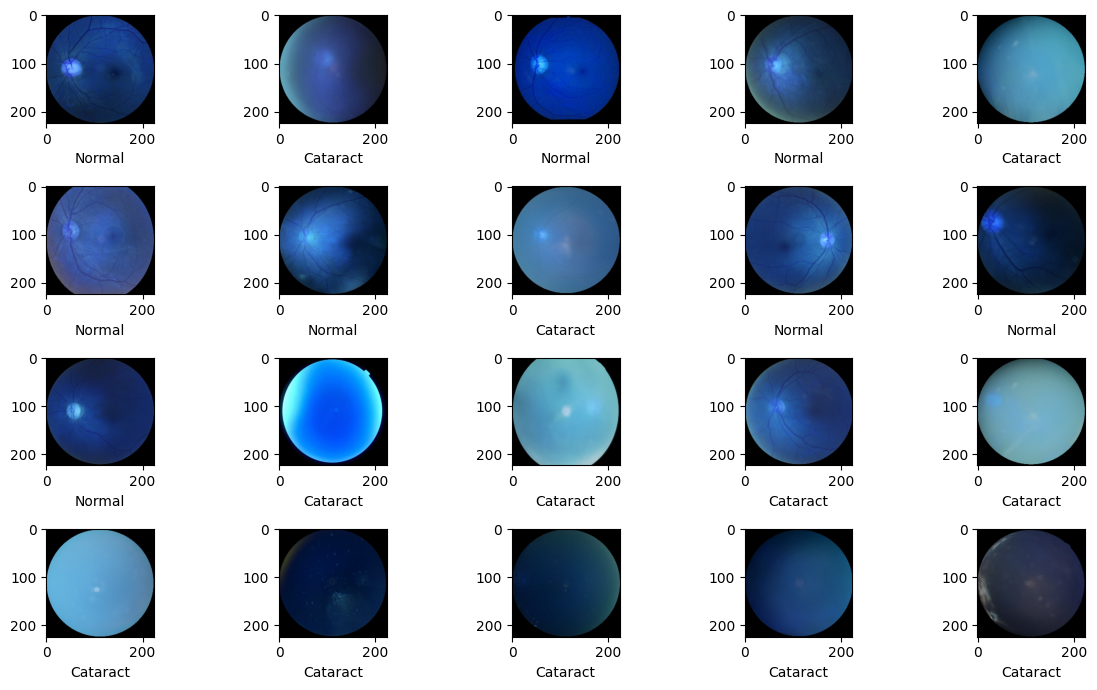

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 7))
for i in range(20):
  sample = random.choice(range(len(dataset)))
  image = dataset[sample][0]
  category = dataset[sample][1]
  label = 'Normal' if category == 0 else 'Cataract'
  plt.subplot(4, 5, i+1)
  plt.imshow(image)
  plt.xlabel(label)
plt.tight_layout()

In [71]:
# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

In [72]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from keras.applications.resnet import ResNet50

# Load the pre-trained ResNet-50 model with ImageNet weights
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(image_size,image_size,3))
base_model.save("model_name.h5")

from tensorflow.keras.models import load_model
resnet = load_model('model_name.h5')

# Create a new model based on ResNet-50
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[early_stopping])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,278,337
Trainable params: 49,225,217
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/15
 4/30 [===>...............

In [54]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 47s 6s/step - loss: 0.6897 - accuracy: 0.8235
Test Loss: 0.689748227596283
Test Accuracy: 0.8235294222831726


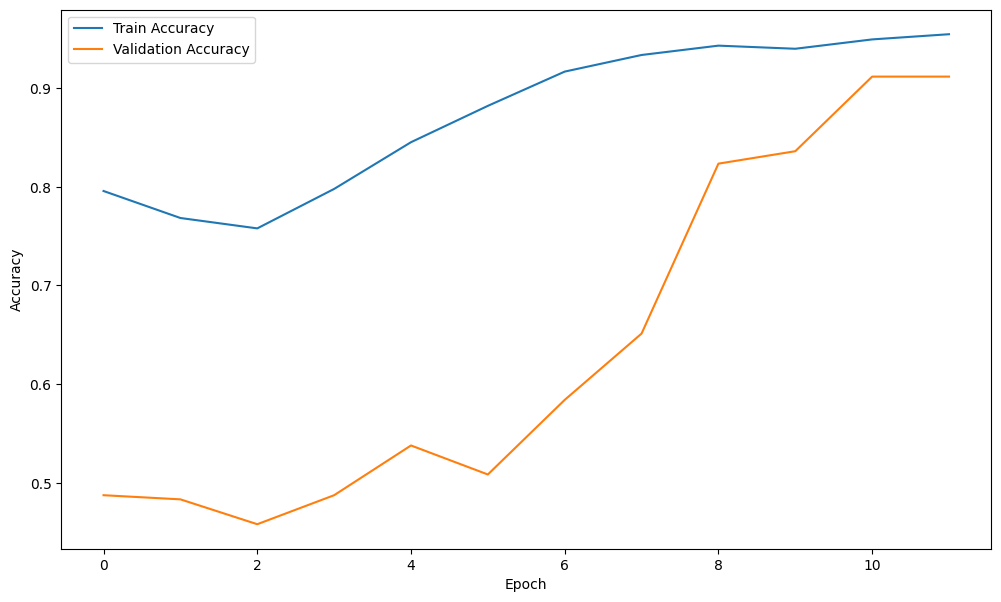

In [55]:
# Plot the training history
plt.figure(figsize=(12, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

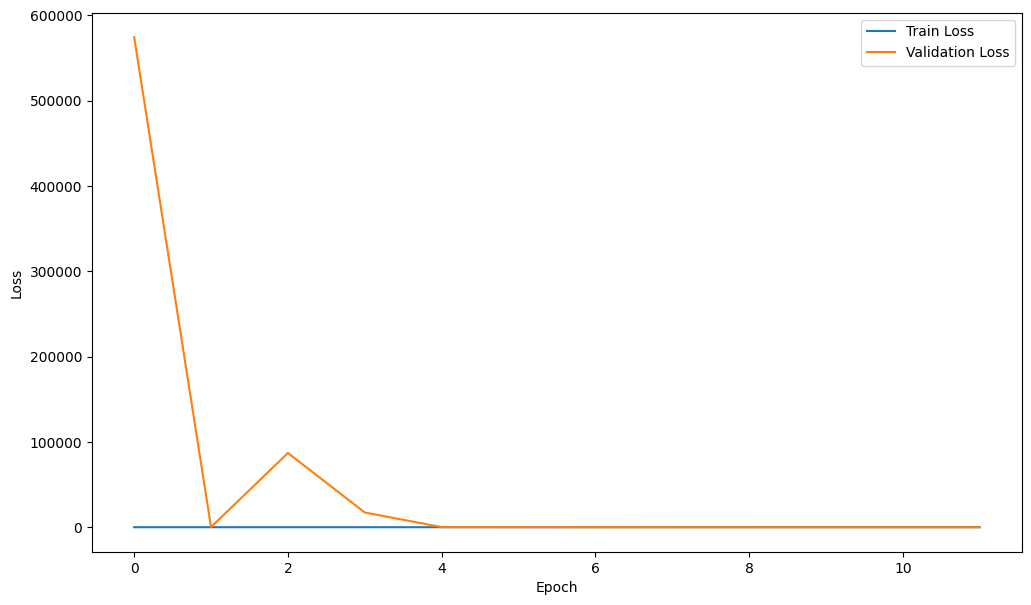

In [56]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
# Generate predictions on the testing set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

8/8 [==============================] - 54s 7s/step


In [58]:
# Convert labels to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1])
y_pred_proba = y_pred

In [59]:
# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

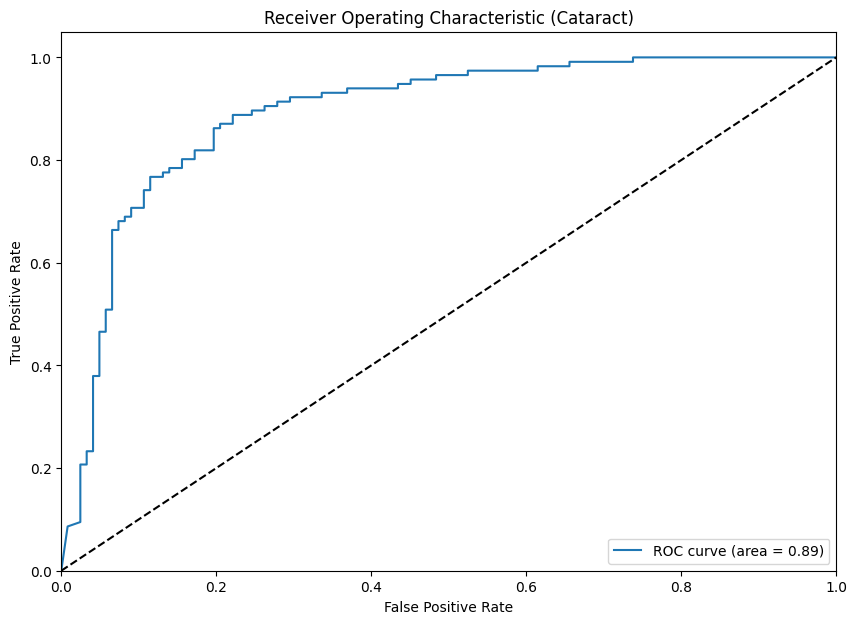

In [60]:
# Plot ROC curve for cataract class
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cataract)')
plt.legend(loc="lower right")
plt.show()

In [61]:
# Generate classification report
target_names = ['Normal', 'Cataract']
classification_rep = classification_report(y_test, y_pred_binary, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

      Normal       0.86      0.78      0.82       122
    Cataract       0.79      0.87      0.83       116

    accuracy                           0.82       238
   macro avg       0.83      0.82      0.82       238
weighted avg       0.83      0.82      0.82       238



In [62]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 48s 6s/step - loss: 0.6897 - accuracy: 0.8235
Test Loss: 0.689748227596283
Test Accuracy: 0.8235294222831726


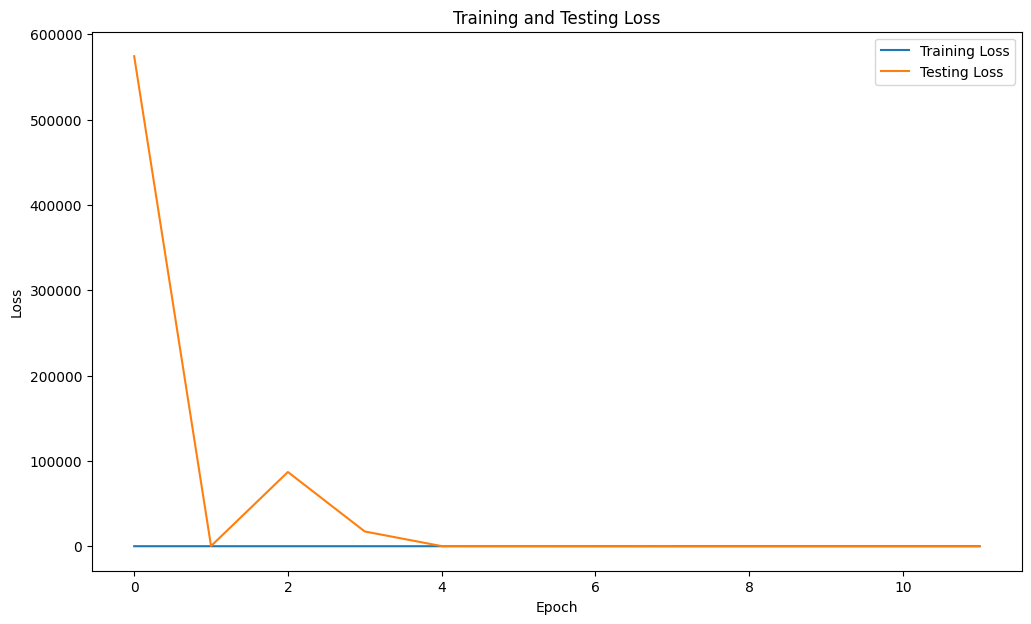

In [63]:
# Plot the training and validation loss
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()